In [67]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from helper import view_classify

In [68]:
# Normalization function for the images from [0, 255] to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
                              ])

In [69]:
batch_size = 64
# Download the training and testing MNIST dataset
trainset = datasets.MNIST('training-data', download=True, train=True, transform = transform)
valset = datasets.MNIST('training-data', download=True, train=False, transform = transform)

# Partitioning the dataset into batches for training and testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [70]:
# iterator to iterate through our training data set
dataiter = iter(trainloader)
images, labels = dataiter.next()

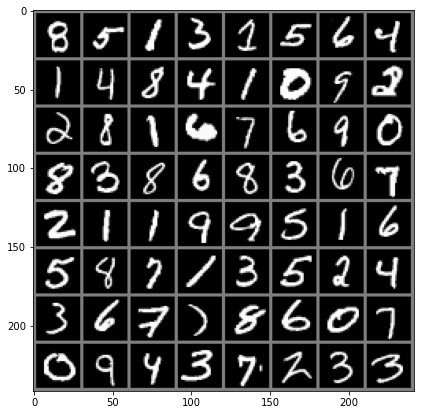

In [71]:
# Simple grid to have a glance at the training dataset
plt.figure(figsize=(7,7))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [72]:
# model
import torch.nn.functional as F

model = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(12, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(24, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(),
    
            # Flatten the input to feed into the dense layers
            nn.Flatten(),

            # Dense layers
            nn.Linear(in_features=32*7*7, out_features=200, bias=False),
            nn.BatchNorm1d(200, affine=True),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=200, out_features=10, bias=False),
            nn.LogSoftmax(dim=1))

In [191]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# cross-entropy loss for the model train (using negative log-likelihood loss)
criterion = nn.NLLLoss()

# Training the model
def train(epoch):
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

for epoch in range(10):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.363451
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.155996
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.164043
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.222186
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.256065
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.180780
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.081814
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.017608
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.219298
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.038354

Test set: Avg. loss: 0.0571, Accuracy: 9810/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.154366
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.205071
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.113316
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.062606
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.028938
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.047689
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.112904
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.121189
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026331
Trai

predicted digit =  4


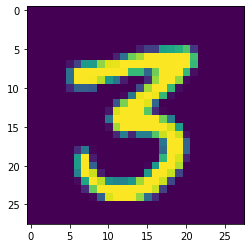

In [76]:
# An image prediction, output a class probability
images , labels = next(iter(valloader))
with torch.no_grad():
    logps = model(images)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("predicted digit = ", probab.index(max(probab)))
plt.imshow(images[0][0])
#view_classify(img.view(1, 28, 28), ps)

In [193]:
# Checking model performance with the testing dataset
def test():
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valloader:
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss += F.nll_loss(output, target, reduction='sum').item()
    test_loss /= len(valloader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valloader.dataset),
        100. * correct / len(valloader.dataset)))
test()


Test set: Avg. loss: 0.0422, Accuracy: 9887/10000 (99%)



In [195]:
# Saving model
torch.save(model, './models/conv2d_model.pt')